## Tokenizing .loom or .h5ad single cell RNA-seq data to rank value encoding .dataset format

#### Input data is a directory with .loom or .h5ad files containing raw counts from single cell RNAseq data, including all genes detected in the transcriptome without feature selection. The input file type is specified by the argument file_format in the tokenize_data function.

#### The discussion below references the .loom file format, but the analagous labels are required for .h5ad files, just that they will be column instead of row attributes and vice versa due to the transposed format of the two file types.

#### Genes should be labeled with Ensembl IDs (loom row attribute "ensembl_id"), which provide a unique identifer for conversion to tokens. Other forms of gene annotations (e.g. gene names) can be converted to Ensembl IDs via Ensembl Biomart. Cells should be labeled with the total read count in the cell (loom column attribute "n_counts") to be used for normalization.

#### No cell metadata is required, but custom cell attributes may be passed onto the tokenized dataset by providing a dictionary of custom attributes to be added, which is formatted as loom_col_attr_name : desired_dataset_col_attr_name. For example, if the original .loom dataset has column attributes "cell_type" and "organ_major" and one would like to retain these attributes as labels in the tokenized dataset with the new names "cell_type" and "organ", respectively, the following custom attribute dictionary should be provided: {"cell_type": "cell_type", "organ_major": "organ"}. 

#### Additionally, if the original .loom file contains a cell column attribute called "filter_pass", this column will be used as a binary indicator of whether to include these cells in the tokenized data. All cells with "1" in this attribute will be tokenized, whereas the others will be excluded. One may use this column to indicate QC filtering or other criteria for selection for inclusion in the final tokenized dataset.

#### If one's data is in other formats besides .loom or .h5ad, one can use the relevant tools (such as Anndata tools) to convert the file to a .loom or .h5ad format prior to running the transcriptome tokenizer.

#### OF NOTE: PLEASE ENSURE THE CORRECT TOKEN DICTIONARY AND GENE MEDIAN FILE IS USED FOR THE CORRECT MODEL.

#### The 95M model series also require the special_token argument to be set to True and model_input_size to be 4096.

In [1]:
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

import sys

sys.path.append("../src/models/src_geneformer")

# Import the geneformer module first
import geneformer
from pathlib import Path

# for human
# GENE_MEDIAN_FILE = (
#     Path("../data/human/weights/human-Geneformer/gene_dictionaries_30m") / "gene_median_dictionary_gc95M.pkl"
# )
# TOKEN_DICTIONARY_FILE = (
#     Path("../data/human/weights/human-Geneformer/gene_dictionaries_30m") / "token_dictionary_gc95M.pkl"
# )
# ENSEMBL_DICTIONARY_FILE = (
#     Path("../data/human/weights/human-Geneformer/gene_dictionaries_30m") / "gene_name_id_dict_gc95M.pkl"
# )
# ENSEMBL_MAPPING_FILE = (
#     Path("../data/human/weights/human-Geneformer/gene_dictionaries_30m") / "ensembl_mapping_dict_gc95M.pkl"
# )

# for mouse
GENE_MEDIAN_FILE = (
    Path("../data/mouse/weights/mouse-Geneformer/") / "mouse_gene_median_dictionary.pkl"
)
TOKEN_DICTIONARY_FILE = (
    Path("../data/mouse/weights/mouse-Geneformer/") / "MLM-re_token_dictionary_v1.pkl"
)
ENSEMBL_DICTIONARY_FILE = (
    Path("../data/mouse/weights/mouse-Geneformer/")
    / "MLM-re_token_dictionary_v1_GeneSymbol_to_EnsemblID.pkl"
)
ENSEMBL_MAPPING_FILE = (
    Path("../data/mouse/weights/mouse-Geneformer/")
    / "MLM-re_All_mouse_tokenize_dataset_length.pkl"
)

# Now import TranscriptomeTokenizer after modifying the constants
from geneformer import TranscriptomeTokenizer

/Users/barteksadlej/miniconda3/envs/tml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tk = TranscriptomeTokenizer(
    {"cell_type": "cell_type"},
    nproc=16,
    special_token=False,
    gene_median_file=GENE_MEDIAN_FILE,
    token_dictionary_file=TOKEN_DICTIONARY_FILE,
    gene_mapping_file=ENSEMBL_MAPPING_FILE,
)
output = tk.tokenize_anndata(
    "../data/mouse/samples/transformed_25705be4-c454-4c8c-b227-b8968fb1f307.h5ad",
)

../data/mouse/samples/transformed_25705be4-c454-4c8c-b227-b8968fb1f307.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


In [3]:
len(output[1]["cell_type"])

906

In [4]:
sample_tokens = output[0]
sample_tokens[0]

array([18562, 44514, 12218, ...,  5297,  8874,  3001])

In [5]:
from scanpy import read_h5ad
import pandas as pd

pd.set_option("display.max_columns", None)

data = read_h5ad(
    "../data/mouse/samples/transformed_25705be4-c454-4c8c-b227-b8968fb1f307.h5ad",
)

data.obs

,FACS.selection,age,cell,free_annotation,method,donor_id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,disease_ontology_term_id,cell_type_ontology_term_id,tissue_ontology_term_id,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,is_primary_data,organism_ontology_term_id,suspension_type,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A15_B002505_B008538_S15.mm10-plus-5-0,Viable,18m,A15_B002505,nan,facs,18_45_M,3857,2349987.0,1,9,EFO:0008931,PATO:0000461,CL:0002548,UBERON:0000947,MmusDv:0000089,na,PATO:0000384,False,NCBITaxon:10090,cell,tissue,fibroblast of cardiac tissue,Smart-seq2,normal,Mus musculus,male,aorta,na,18-month-old stage,P(1VrqP}u-
A16_D045849_B008537_S16.mm10-plus-5-0,Viable,18m,A16_D045849,nan,facs,18_47_F,926,422384.0,10,2,EFO:0008931,PATO:0000461,CL:0002544,UBERON:0000947,MmusDv:0000089,na,PATO:0000383,False,NCBITaxon:10090,cell,tissue,aortic endothelial cell,Smart-seq2,normal,Mus musculus,female,aorta,na,18-month-old stage,$8!aefxLPe
A17_D045849_B008537_S17.mm10-plus-5-0,Viable,18m,A17_D045849,nan,facs,18_47_F,1905,2252577.0,8,4,EFO:0008931,PATO:0000461,CL:0002544,UBERON:0000947,MmusDv:0000089,na,PATO:0000383,False,NCBITaxon:10090,cell,tissue,aortic endothelial cell,Smart-seq2,normal,Mus musculus,female,aorta,na,18-month-old stage,g^e$w6)1zM
A18_B002505_B008538_S18.mm10-plus-5-0,Viable,18m,A18_B002505,nan,facs,18_45_M,2233,694789.0,5,6,EFO:0008931,PATO:0000461,CL:0002544,UBERON:0000947,MmusDv:0000089,na,PATO:0000384,False,NCBITaxon:10090,cell,tissue,aortic endothelial cell,Smart-seq2,normal,Mus musculus,male,aorta,na,18-month-old stage,fi2Y7eKV>D
A1_B002505_B008538_S1.mm10-plus-5-0,Viable,18m,A1_B002505,nan,facs,18_45_M,2607,584341.0,7,10,EFO:0008931,PATO:0000461,CL:0002548,UBERON:0000947,MmusDv:0000089,na,PATO:0000384,False,NCBITaxon:10090,cell,tissue,fibroblast of cardiac tissue,Smart-seq2,normal,Mus musculus,male,aorta,na,18-month-old stage,8@lWXyIVZ<
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P22.B002431.3_39_F.1.1-1-1,nan,3m,P22.B002431.3_39_F.1.1,nan,facs,3_39_F,1579,719453.0,3,0,EFO:0008931,PATO:0000461,CL:0002544,UBERON:0000947,MmusDv:0000063,na,PATO:0000383,False,NCBITaxon:10090,cell,tissue,aortic endothelial cell,Smart-seq2,normal,Mus musculus,female,aorta,na,3-month-old stage,04vWY+ExfA
P22.MAA000906.3_11_M.1.1-1-1,nan,3m,P22.MAA000906.3_11_M.1.1,nan,facs,3_11_M,2201,196885.0,0,3,EFO:0008931,PATO:0000461,CL:0002544,UBERON:0000947,MmusDv:0000063,na,PATO:0000384,False,NCBITaxon:10090,cell,tissue,aortic endothelial cell,Smart-seq2,normal,Mus musculus,male,aorta,na,3-month-old stage,cN~FASiI5q
P22.MAA000908.3_10_M.1.1-1-1,nan,3m,P22.MAA000908.3_10_M.1.1,nan,facs,3_10_M,1688,68255.0,0,4,EFO:0008931,PATO:0000461,CL:0002544,UBERON:0000947,MmusDv:0000063,na,PATO:0000384,False,NCBITaxon:10090,cell,tissue,aortic endothelial cell,Smart-seq2,normal,Mus musculus,male,aorta,na,3-month-old stage,I~#gNO-$Sj


In [6]:
from geneformer import perturber_utils as pu
import torch
import numpy as np

# BACKEND = "cuda" if torch.cuda.is_available() else "cpu"
BACKEND = "mps"

N_SAMPLES = 50

model_type = "CellClassifier"
num_classes = 3
filter_data = {"cell_type": ["Cardiomyocyte1", "Cardiomyocyte2", "Cardiomyocyte3"]}
max_ncells = 1000
emb_layer = 0
emb_label = ["disease", "cell_type"]
emb_mode = "cls"
labels_to_plot = ["disease"]
forward_batch_size = 200
nproc = 16

model = pu.load_model(
    model_type, num_classes, "../data/mouse/weights/mouse-Geneformer/", mode="eval"
)

layer_to_quant = pu.quant_layers(model) + emb_layer

model_input_size = pu.get_model_input_size(model)
model_input_size = 512

minibatch = []
for i in range(len(sample_tokens)):
    minibatch.append(
        np.pad(sample_tokens[i], (0, max(0, model_input_size - len(sample_tokens[i]))))[
            :model_input_size
        ]
    )

minibatch = torch.tensor(minibatch, dtype=torch.long)

minibatch = torch.cat(
    (
        minibatch[:N_SAMPLES, :],
        minibatch[-N_SAMPLES:, :],
    ),
    dim=0,
)

model.to(BACKEND)

BS = 16
cls_embs = []

with torch.no_grad():
    for i in range(0, len(minibatch), BS):
        outputs = model(
            input_ids=minibatch[i : i + BS].to(BACKEND),
            attention_mask=torch.ones_like(minibatch[i : i + BS]).to(BACKEND),
        )

        embs_i = outputs.hidden_states[layer_to_quant]

        if emb_mode == "cls":
            cls_embs.append(embs_i[:, 0, :].detach().cpu().numpy())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../data/mouse/weights/mouse-Geneformer/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/hd/mx96cv413rj0hjyl6_m479l00000gn/T/ipykernel_60968/1665205872.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  minibatch = torch.tensor(minibatch, dtype=torch.long)


In [8]:
cls_embs = np.concatenate(cls_embs, axis=0)
cls_embs.shape

(100, 256)

In [9]:
sample_df_obs = pd.concat(
    (
        data.obs[:N_SAMPLES],
        data.obs[-N_SAMPLES:],
    ),
    axis=0,
)


labels = data.obs["age"].values
labels = np.concatenate([labels[:N_SAMPLES], labels[-N_SAMPLES:]])

In [10]:
import anndata
import scanpy as sc

adata = anndata.AnnData(
    X=cls_embs,
    obs=sample_df_obs,
    var=pd.DataFrame(index=[f"emb_{i}" for i in range(cls_embs.shape[1])]),
)

sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/barteksadlej/miniconda3/envs/tml/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


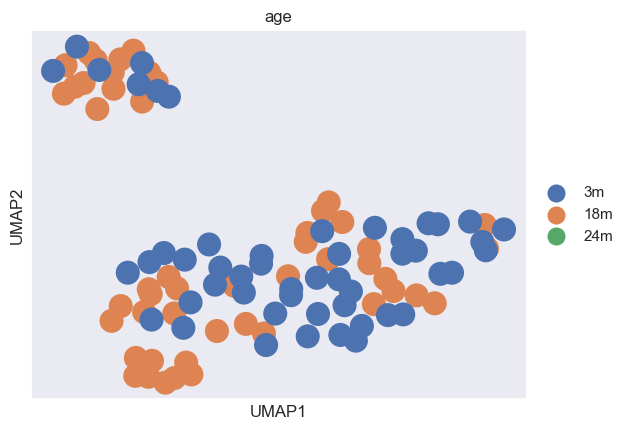

In [11]:
import matplotlib.pyplot as plt

with plt.rc_context():
    ax = sc.pl.umap(adata, color="age", show=False)
    ax.legend(
        markerscale=2,
        frameon=False,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        ncol=1,
    )
    plt.show()

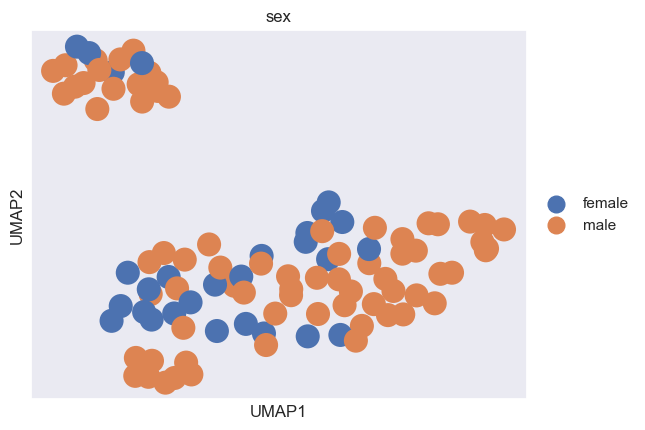

In [13]:
with plt.rc_context():
    ax = sc.pl.umap(adata, color="sex", show=False)
    ax.legend(
        markerscale=2,
        frameon=False,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        ncol=1,
    )
    plt.show()

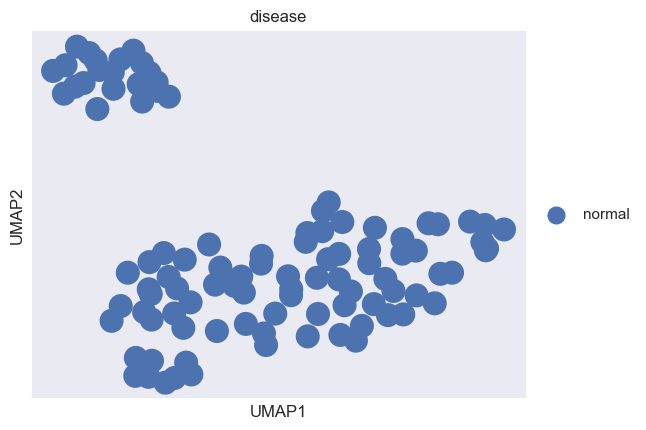

In [14]:
with plt.rc_context():
    ax = sc.pl.umap(adata, color="disease", show=False)
    ax.legend(
        markerscale=2,
        frameon=False,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        ncol=1,
    )
    plt.show()